# Custom CNN Model

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import sys
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import (Dense, Dropout, Flatten, 
                                     Conv2D, MaxPooling2D, BatchNormalization, 
                                     GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import metrics
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers.experimental.preprocessing import (RandomFlip, RandomRotation, 
                                                                RandomZoom, RandomContrast)
# For reproducibility
np.random.seed(42)
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(42)

In [2]:
# Importing global variables
sys.path.append('./Code/Helper')
import helper as hp

Metal device set to: Apple M2 Max


In [111]:
%run Code/Helper/helper.py

In [3]:
base_path = './Data/Final'
w = 48
h = 48
# Flow from directory
# Code modified from: Lesson 8.06-CNN
train = image_dataset_from_directory(
    base_path + '/train',
    image_size=(w,h),
    batch_size=32,
    seed=42,
    validation_split = 0.2,
    subset= 'training',
    color_mode='grayscale',
    label_mode='categorical'
)

val = image_dataset_from_directory(
    base_path + '/train',
    image_size=(w,h),
    batch_size=32,
    seed=42,
    validation_split = 0.2,
    subset= 'validation',
    color_mode='grayscale',
    label_mode='categorical'
)
    
test = image_dataset_from_directory(
    base_path + '/test',
    image_size=(w,h),
    batch_size=32,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle= False
)

Found 50499 files belonging to 7 classes.
Using 40400 files for training.
Found 50499 files belonging to 7 classes.
Using 10099 files for validation.
Found 7178 files belonging to 7 classes.


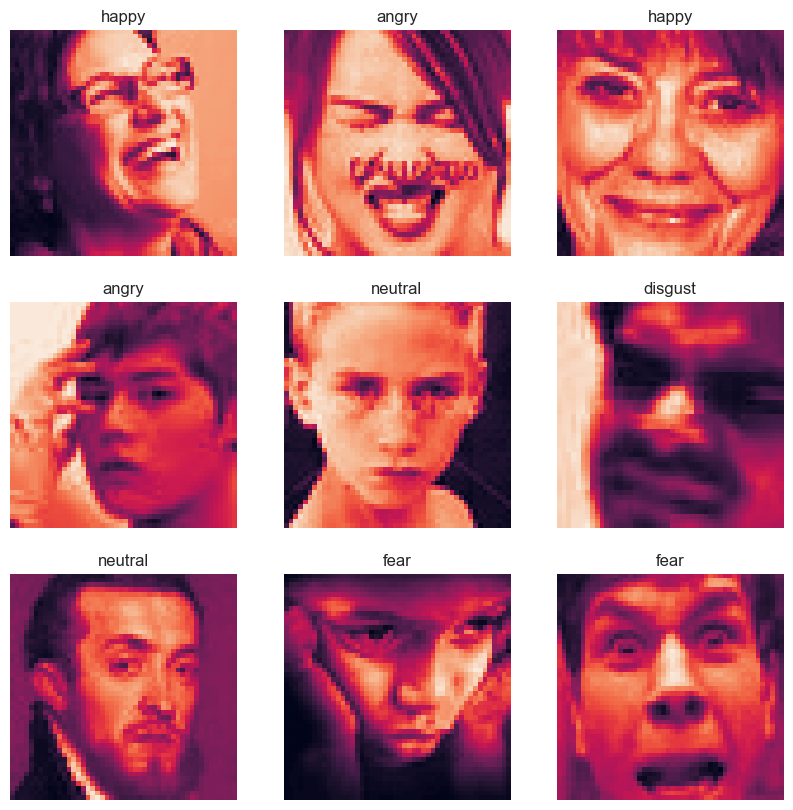

In [7]:
# Show first nine images and label from training set
# Source Code: https://www.tensorflow.org/tutorials/images/transfer_learning
class_names = train.class_names

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    label_index = np.argmax(labels[i]) #Convert one hot encoded label to int
    plt.title(class_names[label_index])
    plt.axis("off")

# Baseline 

To find the baseline accuracy, the majority class will be considered, which is the class with the highest count in the final dataset. Looking at the class distribution below, the majority class is `sad` with 5816 samples.

**The baseline accuracy is the accuracy one would achieve by always predicting the majority class.** Since the dataset is slightly imbalanced, the baseline accuracy would be the proportion of samples in the majority class compared to the total number of samples. 

To calculate the baseline accuracy, we divide the count of the majority class by the majority class by the total number of samples: 

$$
\text{Baseline Accuracy} = \frac{\text{Count of Majority Class}}{\text{Total Number of Samples}}
$$


In this case, **the count of the majority class(`sad`) is 5816**, and the **total number of samples across all class is 40320**. 

$$
\text{Baseline Accuracy} = \frac{5816}{40320} = 0.1440 = 14.40\%
$$


Thus, the baseline accuracy if one were to always predict the majority class `sad`, would be approximately 14.40%
This means that if a model performs worse than the baseline accuracy, it might not be learning meaningful patterns from the data. The goal is to have a model that achieves higher accuracy than the baseline.

In [5]:
hp.print_class_counts(train)

Index 0: angry - Count: 5751, Percentage: 14.24%
Index 1: disgust - Count: 5754, Percentage: 14.24%
Index 2: fear - Count: 5747, Percentage: 14.23%
Index 3: happy - Count: 5746, Percentage: 14.22%
Index 4: neutral - Count: 5802, Percentage: 14.36%
Index 5: sad - Count: 5816, Percentage: 14.40%
Index 6: surprise - Count: 5784, Percentage: 14.32%


# CNN models

## A. CNN model

Model 1 is a simple Convolutional Neural Network(CNN) model trained for a maximum of 50 epochs and has the following architecture: [Source](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
- **Convolutional Layer**: This model consists of three sets of convolutional layers with increasing number of filters (32,64, and 128). Convolutional layers help capture features from the input images.

- **MaxPooling2D Layer**: Max pooling reduces the spatial dimentions of the input feature map while retaining the most important information. It helps model learn faster and control overfitting.

- **Flatter Layer**: The Flatten layer is used to convert the 2D feature maps into a 1D vector. It "flattens" the multidimensional representation into a single vector, which can then be fed into the fully connected layers.

- **Dense (Fully Connected) Layer**: In the baseline model, there is one dense layer with 528 units. Dense layers are responsible for learning complex patterns in the data and making final predictions.

- **Output Layer**: Consists of a dense layer with 7 units (7 different emotion classes) and the softmax activation function.

- **Compilation**: The baseline model uses the Adam optimizer, categorical cross-entropy loss function, and the metrics evaluated are accuracy, precision, recall, and AUC score. 

- **Callbacks**: 
    * The baseline model uses the EarlyStopping callback, which monitors the validation loss and stops training if the validation loss stops improving for 10 consecutive epochs.
    * ReduceLROnPlateau: this callback reduces the learning rate when the validation loss stops improving. This helps fine-tune the model by adjusting the learning rate.
    * Model CheckPoint: this callback saves the best model based on the validation accuracy during training, this is so I can later access the best-performing model later.

In [6]:
model1 = Sequential()

model1.add(layers.Input(shape = (h,w,1)))
# Rescaling the pixel values of the input images between 0 and 1
model1.add(layers.Rescaling(1./255))

#First Convolutional layer
model1.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))

#2nd Convolutional layer
model1.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

#3rd Convolutional layer
model1.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Flatten layer to feed into model
model1.add(Flatten())

#Fully connected layer
#1 Hidden Layer
model1.add(Dense(528, activation = 'relu'))

# Output Layer
model1.add(Dense(7, activation = 'softmax'))

# print out summary of model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [7]:
# Compile
model1.compile(
    optimizer= 'adam',  #default learning rate = 0.001
    loss = 'categorical_crossentropy',
    metrics = ['acc',
               metrics.Precision(),
               metrics.Recall(),
               metrics.AUC()]
)

In [8]:
# Define EarlyStopping callback
es = EarlyStopping(monitor='val_loss',    #check at end of every epoch whether the val_loss is no longer decreasing
                   mode= 'min',
                   patience = 10,
                   verbose = 1)

# Define ReduceLROnPlateau
r_lr = ReduceLROnPlateau(monitor = 'val_loss',   # reduce learning rate by factor of 0.3 if val_loss no longer decreasing
                       factor = 0.3,
                       patience = 3,
                       min_delta = 0.000001,
                       verbose = 1)

# Define ModelCheckpoint
ck = ModelCheckpoint('./Models/model1.h5')

In [9]:
h1 = model1.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks = [es, r_lr, ck],
    verbose=1
)

Epoch 1/50
1263/1263 [==============================] - 29s 20ms/step - loss: 1.4356 - acc: 0.4401 - precision_1: 0.7577 - recall_1: 0.2124 - auc_1: 0.8123 - val_loss: 1.2407 - val_acc: 0.5247 - val_precision_1: 0.7879 - val_recall_1: 0.3108 - val_auc_1: 0.8658 - lr: 0.0010
Epoch 2/50
1263/1263 [==============================] - 25s 20ms/step - loss: 1.1169 - acc: 0.5737 - precision_1: 0.7734 - recall_1: 0.3836 - auc_1: 0.8935 - val_loss: 1.2099 - val_acc: 0.5450 - val_precision_1: 0.7189 - val_recall_1: 0.4012 - val_auc_1: 0.8764 - lr: 0.0010
Epoch 3/50
1263/1263 [==============================] - 25s 20ms/step - loss: 0.8871 - acc: 0.6683 - precision_1: 0.8011 - recall_1: 0.5334 - auc_1: 0.9340 - val_loss: 1.3252 - val_acc: 0.5554 - val_precision_1: 0.6424 - val_recall_1: 0.4775 - val_auc_1: 0.8766 - lr: 0.0010
Epoch 4/50
1263/1263 [==============================] - 25s 20ms/step - loss: 0.6027 - acc: 0.7844 - precision_1: 0.8552 - recall_1: 0.7114 - auc_1: 0.9692 - val_loss: 1.7560 

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy |  Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |

Model 1 was trained for 12 epochs.
* Accuracy: The model achieved a max validation accuracy of 56.63%, with a training accuracy of 99.62%, which indicates the model may be greatly overfitting to the training dataset and unable to generalize to new and unseen data. The model is performing better than the baseline accuracy of 14.40%.
* Loss: The validation loss (3.8947) is much larger than training loss (0.0196), which indicates that the model is overfitting the training data.


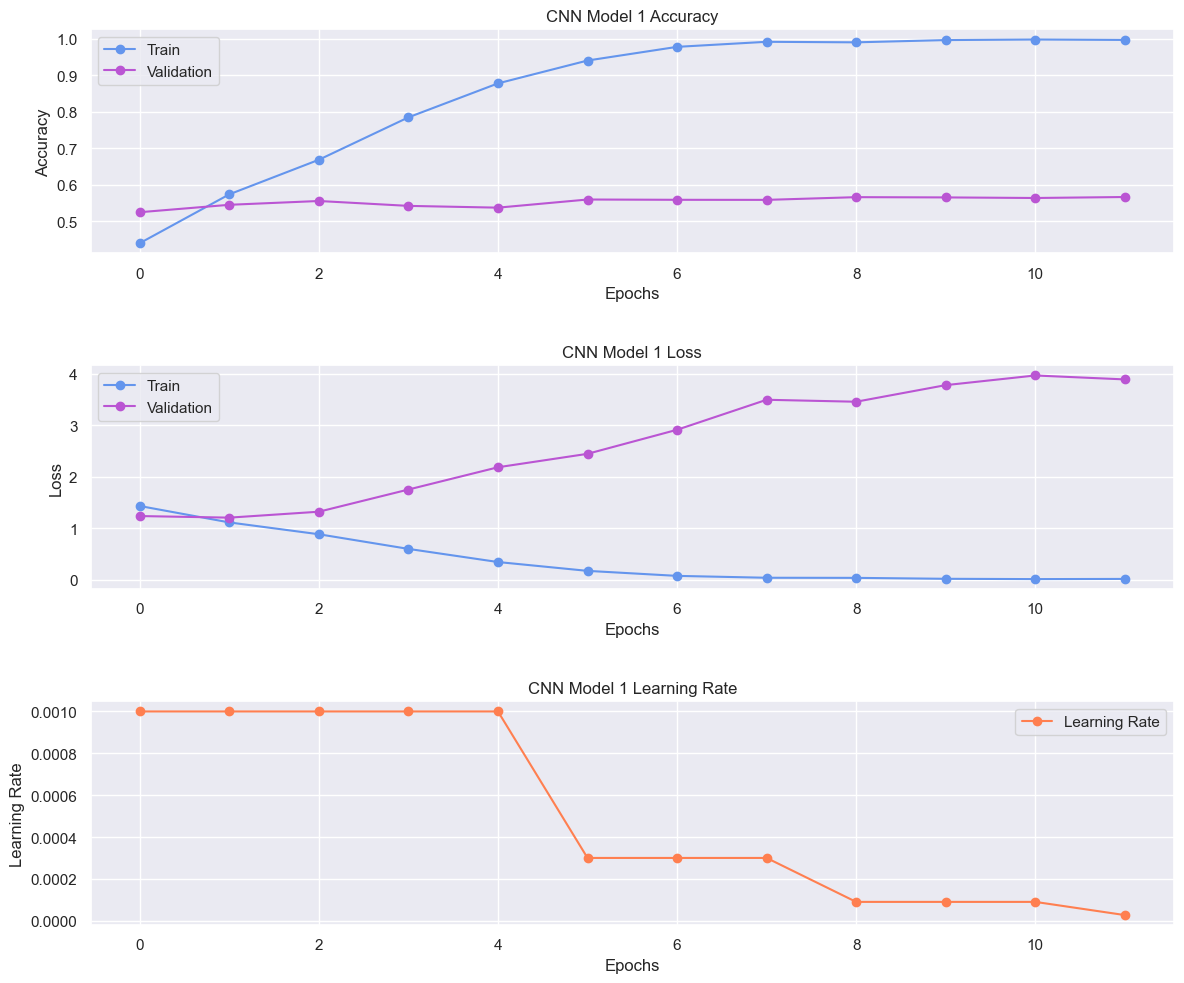

In [10]:
hp.plot_hist(h1, 'CNN Model 1')

* Looking at the graph above we see there is a significant divergence between the two lines. The goal is to minimize the gap between these two lines and see a decreasing trend in the loss and an increasing trend in accuracy.

In [11]:
# Save model history to csv file in Results
hp.model_scores_to_csv(model1, h1, 'cnn_1')

In [17]:
test_eval = model1.evaluate(test)
Loss = test_eval[0]
Acc = test_eval[1]

print(f'Loss:{Loss}\nAcc:{Acc}')

225/225 [==============================] - 3s 11ms/step - loss: 4.3951 - acc: 0.5419 - precision_1: 0.5472 - recall_1: 0.5372 - auc_1: 0.7947
Loss:4.395066738128662
Acc:0.5419337153434753


In [42]:
# Code inspo source: From Project 4 in helper function get_true_and_pred_labels
# Source: https://github.com/annabchox/deepfake-detector/blob/main/Code/Helper/config.py
# Get val dataset as array
dataset_as_array = list(val.as_numpy_iterator())
    
# Separate Image and Label Arrays
label_batches = [dataset_as_array[i][1] for i in range(len(dataset_as_array))]
image_batches = [dataset_as_array[i][0] for i in range(len(dataset_as_array))]
    
# Unpack Image and Label Batches into Single Array
unpacked_label_batches = np.vstack(label_batches)
unpacked_image_batches = np.vstack(image_batches)
    
# Get labels
true_labels = np.argmax(unpacked_label_batches, axis=1)
pred_probs = model1.predict(unpacked_image_batches)
predicted_labels = np.argmax(pred_probs, axis=1)

# Check to make sure length match
print(len(true_labels))
print(len(predicted_labels))

316/316 [==============================] - 3s 9ms/step
10099
10099


In [40]:
total_labels = len(unpacked_label_batches)
print("Total number of labels:", total_labels)
count = sum(true_labels == predicted_labels)
print("Number of matching labels:", count)
acc_pred = (count / total_labels) * 100
print(f"Percent Correct:{acc_pred}%")

Total number of labels: 10099
Number of matching labels: 5719
Percent Correct:56.629369244479655%


In [65]:
# Initialize counters for each class
class_counts = {class_name: {"correct": 0, "incorrect": 0} for class_name in label_dict.values()}

# Iterate through true labels and predicted labels
for true_label, predicted_label in zip(true_labels, predicted_labels):
    true_label_name = label_dict[true_label]
    predicted_label_name = label_dict[predicted_label]
    
    if true_label_name == predicted_label_name:
        class_counts[true_label_name]["correct"] += 1
    else:
        class_counts[true_label_name]["incorrect"] += 1

# Print the distribution of correct and incorrect predictions for each class
for class_name, counts in class_counts.items():
    print("Class:", class_name)
    print("Correct Predictions:", counts["correct"])
    print("Incorrect Predictions:", counts["incorrect"])
    print()

Class: Angry
Correct Predictions: 619
Incorrect Predictions: 843

Class: Disgust
Correct Predictions: 1066
Incorrect Predictions: 396

Class: Fear
Correct Predictions: 678
Incorrect Predictions: 790

Class: Happy
Correct Predictions: 1081
Incorrect Predictions: 388

Class: Neutral
Correct Predictions: 837
Incorrect Predictions: 576

Class: Sad
Correct Predictions: 648
Incorrect Predictions: 751

Class: Surprise
Correct Predictions: 790
Incorrect Predictions: 636



316/316 [==============================] - 2s 6ms/step


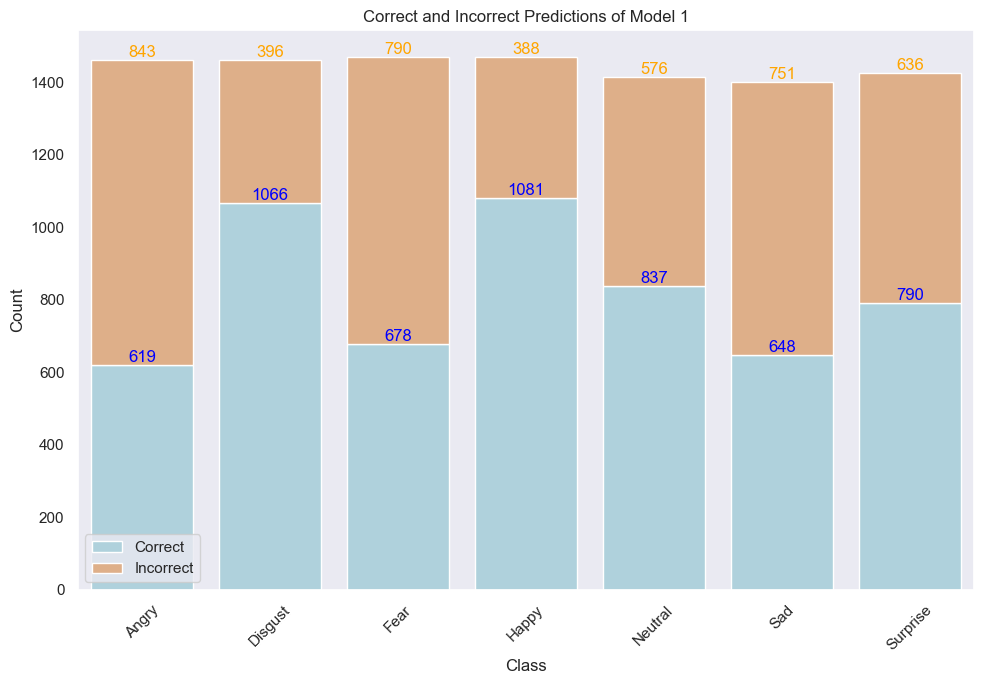

In [112]:
hp.plot_correct_dist(val, model1, 'Model 1')

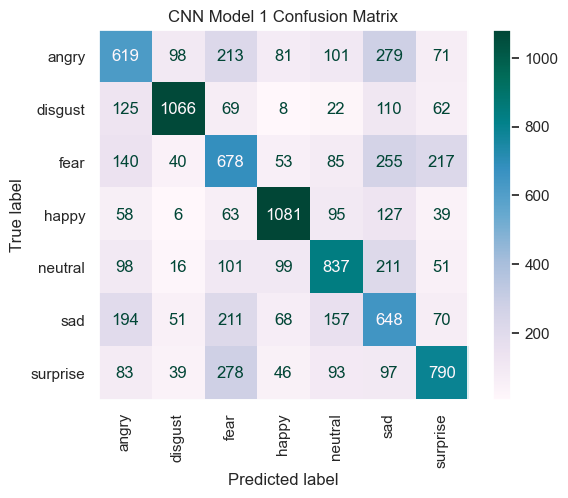

In [22]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
class_names = val.class_names
sns.set(style="dark")
cm1 = ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, display_labels=class_names, cmap='PuBuGn')
plt.title('CNN Model 1 Confusion Matrix')
plt.xticks(rotation = 90)
plt.show();

316/316 [==============================] - 1s 3ms/step


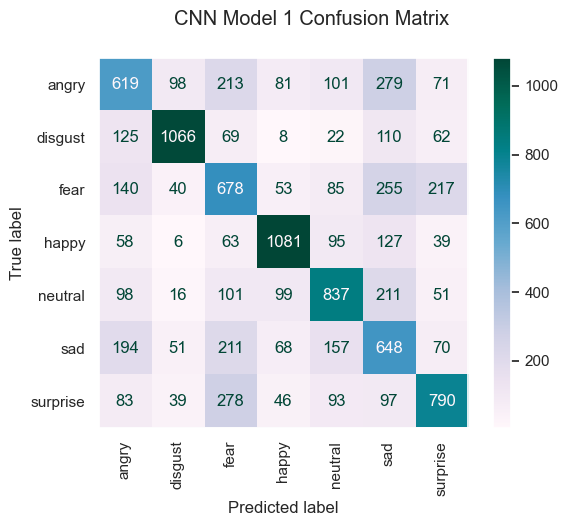

In [12]:
hp.plot_confusion_matrix(val, model1, 'CNN Model 1 Confusion Matrix')

Model 1 is best predicting class **happy** and **disgust**.
Model 1 has the most incorrect predictions for class **fear** and **sad**. 

* Model 1 often incorrectly predicts a surprise, sad, and angry image as fear.
* Model 1 also often incorrectly predicts angry, fear, and neutral as sad. 

# Model 2

Model 2 incorporates batch normalization, dropout, and additional layers in hopes to improves the model's performance in generalizing to new and unseen data, reduce overfitting, and increase it's capacity to learn complex patterns from the data. 

In [113]:
model2 = Sequential()

model2.add(layers.Input(shape = (h,w,1)))
model2.add(layers.Rescaling(1./255))

#First Convolutional layer
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))

#2nd Convolutional layer
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(BatchNormalization())

#3rd Convolutional layer
model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

#4th Convolutional layer
model2.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

#5th Convolutional layer
model2.add(Conv2D(258, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Flatten layer to feed into model
model2.add(Flatten())

#Fully connected layer
#1 Hidden Layer
model2.add(Dense(528, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# Output Layer
model2.add(Dense(7, activation = 'softmax'))

# print out summary of model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)       

In [118]:
# Compile
model2.compile(
    optimizer= Adam(learning_rate=0.0005), #Reduced the learning rate from default (0.001) to 0.0005
    loss = 'categorical_crossentropy',
    metrics = ['acc',
               metrics.Precision(),
               metrics.Recall(),
               metrics.AUC()]
)

In [119]:
es = EarlyStopping(patience = 10,
                   monitor = 'val_loss',
                   mode = 'min',
                  verbose = 1)

r_lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.3,
                       patience = 3,
                       min_delta = 0.000001,
                       verbose = 1)

ck = ModelCheckpoint('./Models/model2.h5')

In [120]:
h2 = model2.fit(train, 
                validation_data = val,
                epochs = 50,
                callbacks = [es, r_lr, ck],
                verbose = 1)

Epoch 1/50
1263/1263 [==============================] - 36s 26ms/step - loss: 1.9445 - acc: 0.2873 - precision_7: 0.4453 - recall_7: 0.1230 - auc_7: 0.6621 - val_loss: 2.6408 - val_acc: 0.1736 - val_precision_7: 0.1943 - val_recall_7: 0.1480 - val_auc_7: 0.5990 - lr: 5.0000e-04
Epoch 2/50
1263/1263 [==============================] - 31s 24ms/step - loss: 1.4922 - acc: 0.4260 - precision_7: 0.6454 - recall_7: 0.2387 - auc_7: 0.8018 - val_loss: 1.4247 - val_acc: 0.4662 - val_precision_7: 0.7563 - val_recall_7: 0.2069 - val_auc_7: 0.8197 - lr: 5.0000e-04
Epoch 3/50
1263/1263 [==============================] - 31s 24ms/step - loss: 1.3323 - acc: 0.4868 - precision_7: 0.6841 - recall_7: 0.3065 - auc_7: 0.8458 - val_loss: 1.3189 - val_acc: 0.4812 - val_precision_7: 0.6895 - val_recall_7: 0.2913 - val_auc_7: 0.8480 - lr: 5.0000e-04
Epoch 4/50
1263/1263 [==============================] - 31s 25ms/step - loss: 1.2356 - acc: 0.5233 - precision_7: 0.7087 - recall_7: 0.3499 - auc_7: 0.8686 - val_l

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy |  Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |
|Model 2 | 0.6844 | 0.7449 | 0.9868 | 0.6309 |

Model 2 was trained for 26 epochs. 


* Validation Loss: Model 2 had a much lower validation loss (0.9868) compared to the Model 1 (3.8947). This suggests that Model 2 generalizes better and performance in terms of minimizing the error on unseen data.
* Validation Accuracy: Model 2 also outperformed Model 1 on validation accuracy, with an accuracy of 63.09% compared to 56.63%. This indicates that Model 2 makes more accurate predictions on the validation set.
* Training Loss and Accuracy: However, Model 1 had much lower training loss (0.0196) than Model 2 (0.6844) and a higher training accuracy (99.62%) compared to Model 2(68.44%). This suggests that Model 1 may have overfit the training data to some extent, while Model 2 had a higher level of training error.

Overall, Model 2 is performing better and is not as overfit to the training data compared to Model 1.

In [121]:
# Save model history to csv file in Results
hp.model_scores_to_csv(model2, h2, 'cnn_2')

In [82]:
# serialize model to JSON
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)

# serialize weights to HDF5
model2.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


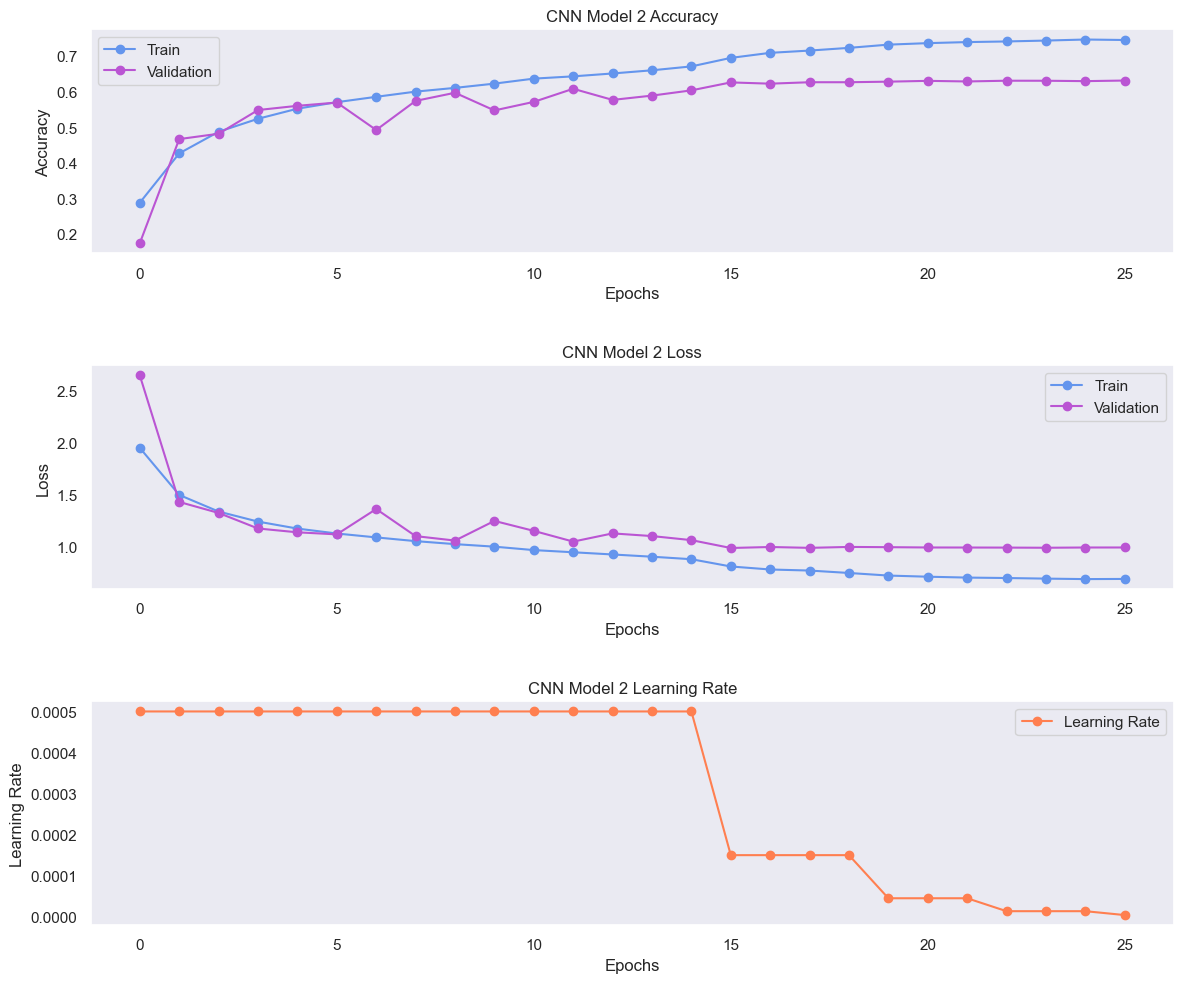

In [122]:
# Plot model loss and accuracy
hp.plot_hist(h2, 'CNN Model 2')

- The distance between the lines in the lineplot above has decreased significantly compared to Model 1, indicating that the model is overfitting much less to the train dataset and learning the patterns much more accurately in the testing dataset.
- The Learning Rate drops by a factor of 0.3 at epoch 15 compared to Model 1, where the learning rate drops by a factor of 0.3 at epoch 5.

316/316 [==============================] - 1s 4ms/step


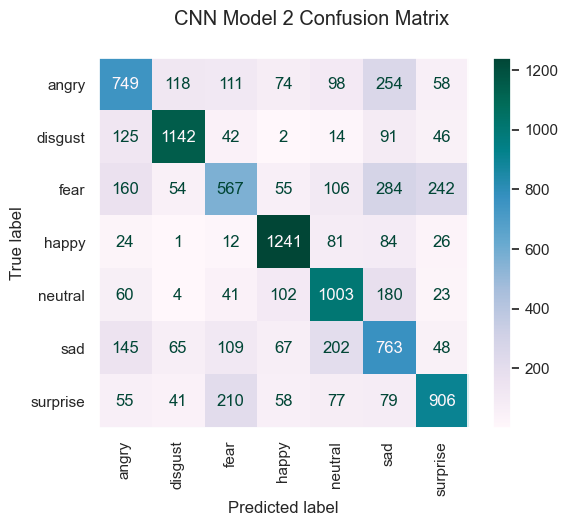

In [123]:
hp.plot_confusion_matrix(val, model2, 'CNN Model 2 Confusion Matrix')

Comparing the Confusion Matrix and bar graph of the distributions of correct/incorrect predictions in Model 2 with Model 1, we see the following highlights:

- Model 2 predicts **more true postives in class**:
     - **angry** (749) than Model 1 (619)
    - **disgust** (1142) than Model 1 (1066)
    - **happy** (1241) than Model 1 (1081)
    - **neutral** (1003) than Model 1 (837)
    - **sad** (763) than Model 2 (648)
    - **surprise** (906) than Model 1 (790)

- Model 2 predicts less true postives in class:
    - **fear** (567) than Model 1 (678)
    
    
Majority of incorrect predictions are made between angry/sad, fear/sad, and surprise/fear.

316/316 [==============================] - 1s 4ms/step


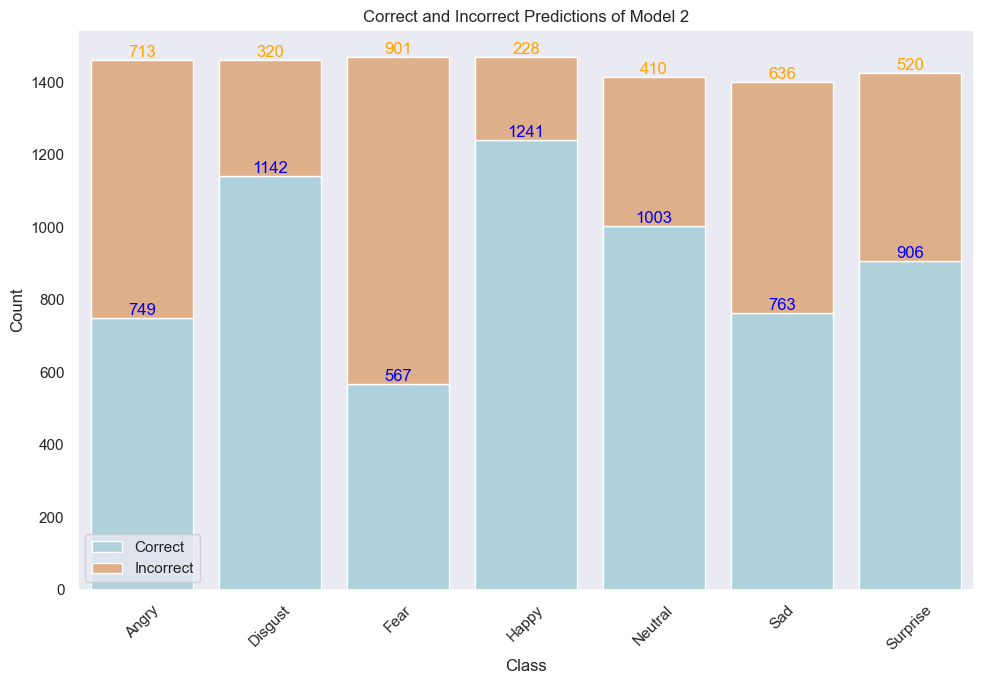

In [124]:
hp.plot_correct_dist(val, model2, 'Model 2')

# Model 3

Several changes and additions were made in model 3, compared to model 2. 

- Additional Hidden Layers: Model 3 introduces a 2 more Hidden layers to perform more feature extraction and learning more complex patterns from previous feature maps. 
- Additional Dropout Layers: Model 3 introduces more drop out layers. This is to prevent overfitting and improve generalization to unseen and new data.


In [125]:
model3 = Sequential()

model3.add(layers.Input(shape = (h,w,1)))
model3.add(layers.Rescaling(1./255))

#First Convolutional layer
model3.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))

#2nd Convolutional layer
model3.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())

#3rd Convolutional layer
model3.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

#4th Convolutional layer
model3.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# 5th Convolutional layer
model3.add(Conv2D(258, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# Flatten layer to feed into model
model3.add(Flatten())

#Fully connected layer
#1 Hidden Layer
model3.add(Dense(528, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))      

#2nd Hidden Layer(Added)
model3.add(Dense(528, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))             

#3rd Hidden Layer(Added)
model3.add(Dense(620, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.6))

# Output Layer
model3.add(Dense(7, activation = 'softmax'))

# print out summary of model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 22, 22, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)       

In [126]:
# Compile
model3.compile(
    optimizer= Adam(learning_rate= 0.0005), 
    loss = 'categorical_crossentropy',
    metrics = ['acc',
               metrics.Precision(),
               metrics.Recall(),
               metrics.AUC()]
)

In [127]:
es = EarlyStopping(patience = 10,
                   monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.3,
                       patience = 3,
                       min_delta = 0.000001,
                       verbose = 1)

ck = ModelCheckpoint('./Models/model3.h5')

In [128]:
h3 = model3.fit(train, 
                validation_data = val,
                epochs = 50,
                callbacks = [es, lr, ck],
                verbose = 1)

Epoch 1/50
1263/1263 [==============================] - 40s 31ms/step - loss: 2.2149 - acc: 0.2362 - precision_8: 0.3244 - recall_8: 0.0932 - auc_8: 0.6017 - val_loss: 1.8973 - val_acc: 0.2516 - val_precision_8: 0.7382 - val_recall_8: 0.0170 - val_auc_8: 0.6112 - lr: 5.0000e-04
Epoch 2/50
1263/1263 [==============================] - 38s 30ms/step - loss: 1.6273 - acc: 0.3753 - precision_8: 0.6394 - recall_8: 0.1793 - auc_8: 0.7544 - val_loss: 1.5009 - val_acc: 0.3936 - val_precision_8: 0.6989 - val_recall_8: 0.1816 - val_auc_8: 0.7936 - lr: 5.0000e-04
Epoch 3/50
1263/1263 [==============================] - 39s 31ms/step - loss: 1.4130 - acc: 0.4516 - precision_8: 0.6988 - recall_8: 0.2537 - auc_8: 0.8230 - val_loss: 1.5219 - val_acc: 0.3731 - val_precision_8: 0.7669 - val_recall_8: 0.1427 - val_auc_8: 0.7903 - lr: 5.0000e-04
Epoch 4/50
1263/1263 [==============================] - 39s 31ms/step - loss: 1.2996 - acc: 0.4942 - precision_8: 0.7143 - recall_8: 0.3032 - auc_8: 0.8535 - val_l

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy |  Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |
|Model 2 | 0.6844 | 0.7449 | 0.9868 | 0.6309 |
|Model 3 | 0.6391 | 0.7629 | 0.9745 | 0.6313 |

Model 3 was trained for 36 epochs. 


* Validation Loss: Model 3 had a lower validation loss (0.9745) compared to the Model 2 (0.9868). This suggests that Model 3 generalizes better and performance in terms of minimizing the error on unseen data.
* Validation Accuracy: Model 3 also performed slightly better than Model 2 on validation accuracy, with an accuracy of 63.13% compared to 63.09%. This indicates that Model 3 makes more accurate predictions on the validation set.
* Training Loss and Accuracy: Model 3 has a lower training loss and slightly higher train accuracy than Model 2.

Overall, Model 3 is performing better and is not as overfit to the training data compared to Model 2.

In [129]:
# Save model history to csv file in Results
hp.model_scores_to_csv(model3, h3, 'cnn_3')

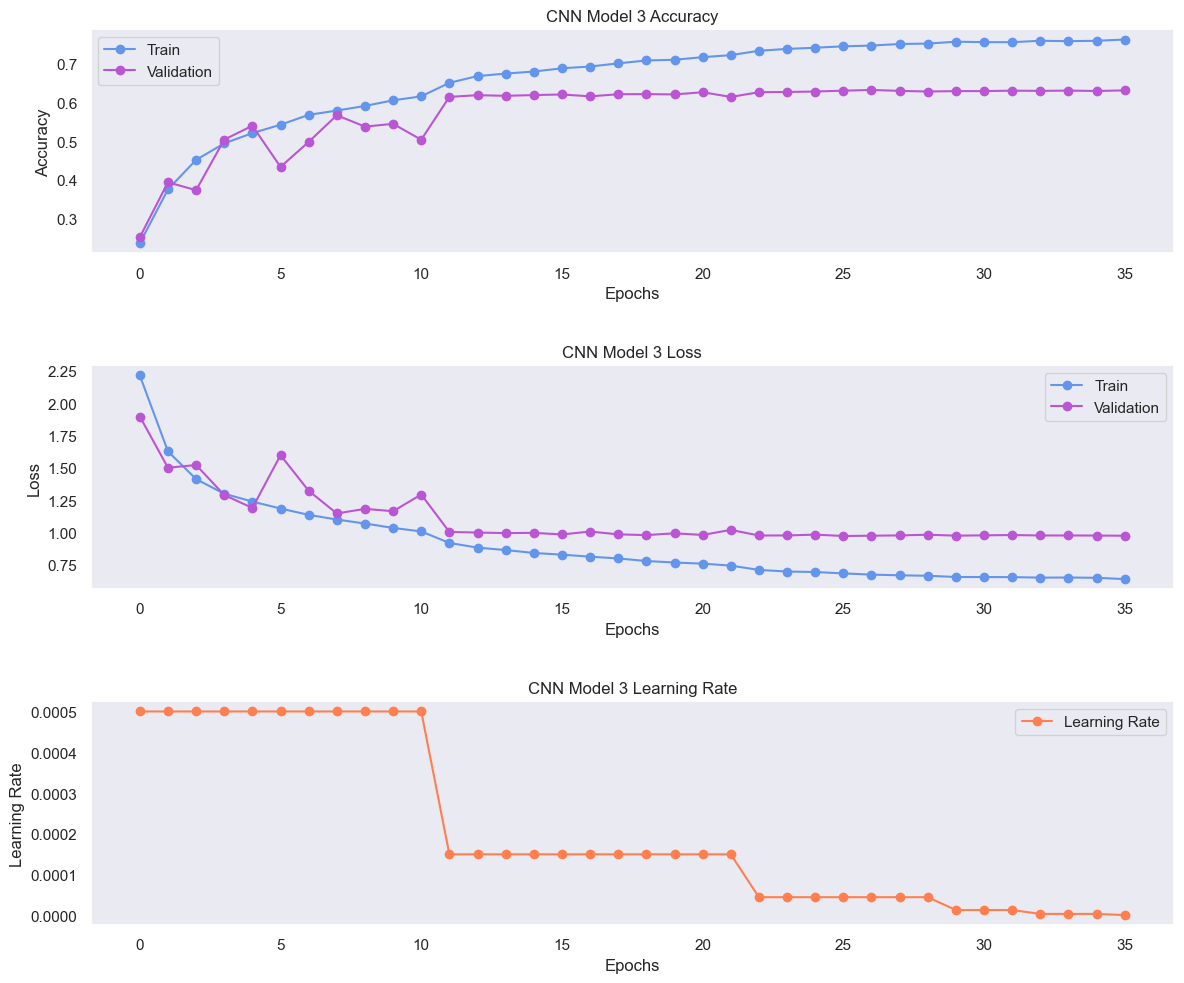

In [130]:
# Plot model loss and accuracy
hp.plot_hist(h3, 'CNN Model 3')

- The distance between the lines in the lineplot above has decreased compared to Model 2, indicating that the model is overfitting less to the train dataset. 
- The Learning Rate drops by a factor of 0.3 at epoch 10 compared to Model 2, where the learning rate drops by a factor of 0.3 at epoch 15.

316/316 [==============================] - 1s 4ms/step


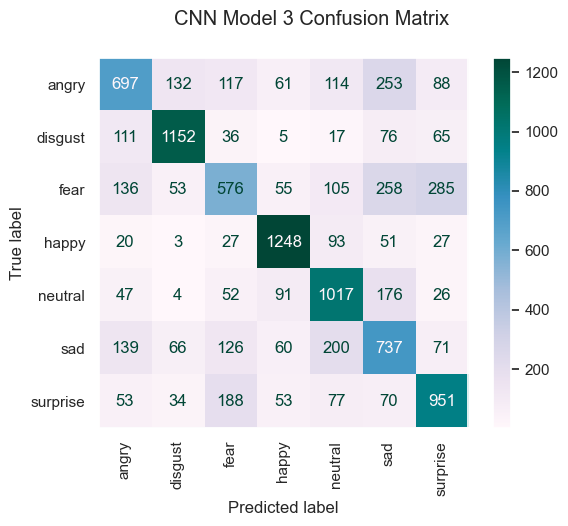

In [32]:
hp.plot_confusion_matrix(val, model3, 'CNN Model 3 Confusion Matrix')

316/316 [==============================] - 1s 4ms/step


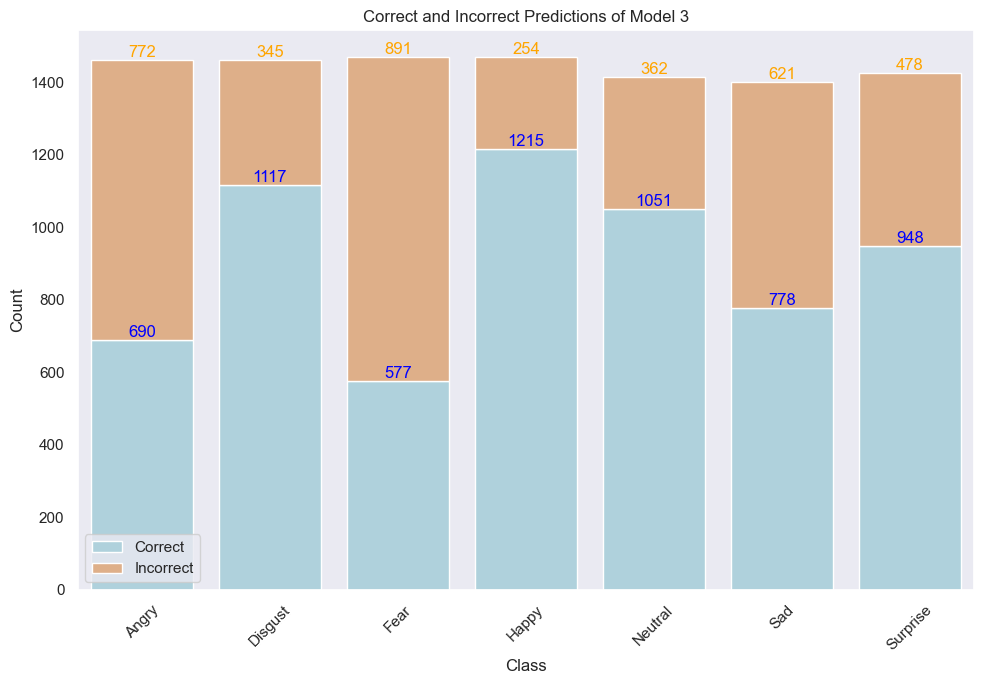

In [132]:
hp.plot_correct_dist(val, model3, 'Model 3')

Comparing the Confusion Matrix and bar graph of the distributions of correct/incorrect predictions in Model 3 with Model 2, we see the following highlights:

- Model 3 predicts more true postives in class:
    - disgust (1152) than Model 2 (1142)
    - fear (576) than Model 2 (567)
    - happy (1248) than Model 2 (1241)
    - neutral (1017) than Model 2 (1003)
    - surprise (951) than Model 2 (906)

- Model 3 predicts less true postives in class:
    - angry (697) than Model 2 (749)
    - sad (737) than Model 2 (763)
    
Majority of incorrect predictions are made between angry/sad, fear/sad, and surprise/fear.

# Model 4

In [154]:
model4 = Sequential()

model4.add(layers.Input(shape = (h,w,1)))
model4.add(layers.Rescaling(1./255))

#First Convolutional layer
model4.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))

#2nd Convolutional layer
model4.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

#3rd Convolutional layer
model4.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))  
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))   #decreased dropout from 0.25 to 0.2

#4th Convolutional layer
model4.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

# 5th Convolutional layer
model4.add(Conv2D(258, kernel_size = (3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# Flatten layer to feed into model
model4.add(Flatten())

#Fully connected layer
#1 Hidden Layer
model4.add(Dense(528, activation = 'relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

#2 Hidden Layer
model4.add(Dense(528, activation = 'relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

# Output Layer
model4.add(Dense(7, activation = 'softmax'))

# print out summary of model
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_39 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_42 (Bat  (None, 22, 22, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_39 (Dropout)        (None, 22, 22, 64)       

In [155]:
# Compile
model4.compile(
    optimizer= Adam(learning_rate=0.0005),  
    loss = 'categorical_crossentropy',
    metrics = ['acc',
               metrics.Precision(),
               metrics.Recall(),
               metrics.AUC()]
)

In [156]:
es = EarlyStopping(patience = 10,
                   monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.3,   
                       patience = 3,
                       min_delta = 0.000001,
                       verbose = 1)

ck = ModelCheckpoint('./Models/model4.h5')

In [157]:
h4 = model4.fit(train, 
                validation_data = val,
                epochs = 50,
                callbacks = [es, lr, ck],
                verbose = 1)

Epoch 1/50
1263/1263 [==============================] - 45s 34ms/step - loss: 2.1207 - acc: 0.2417 - precision_14: 0.3526 - recall_14: 0.0903 - auc_14: 0.6108 - val_loss: 1.9496 - val_acc: 0.2273 - val_precision_14: 0.6326 - val_recall_14: 0.0657 - val_auc_14: 0.6117 - lr: 5.0000e-04
Epoch 2/50
1263/1263 [==============================] - 41s 32ms/step - loss: 1.5843 - acc: 0.3902 - precision_14: 0.6473 - recall_14: 0.1958 - auc_14: 0.7702 - val_loss: 1.4184 - val_acc: 0.4478 - val_precision_14: 0.8079 - val_recall_14: 0.1970 - val_auc_14: 0.8233 - lr: 5.0000e-04
Epoch 3/50
1263/1263 [==============================] - 42s 33ms/step - loss: 1.3834 - acc: 0.4623 - precision_14: 0.6891 - recall_14: 0.2696 - auc_14: 0.8313 - val_loss: 1.2486 - val_acc: 0.5119 - val_precision_14: 0.7881 - val_recall_14: 0.2870 - val_auc_14: 0.8646 - lr: 5.0000e-04
Epoch 4/50
1263/1263 [==============================] - 42s 33ms/step - loss: 1.2777 - acc: 0.5037 - precision_14: 0.7096 - recall_14: 0.3162 - a

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy |  Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |
|Model 2 | 0.6844 | 0.7449 | 0.9868 | 0.6309 |
|Model 3 | 0.6391 | 0.7629 | 0.9745 | 0.6313 |
|Model 4 | 0.6605 | 0.7511 | 0.9612 | 0.6446 |

Model 4 was trained for 42 epochs. 


* Validation Loss: Model 4 had a slightly lower validation loss (0.9612) compared to the Model 3 (0.9745). This suggests that Model 4 generalizes better and performance in terms of minimizing the error on unseen data.
* Validation Accuracy: Model 4 performed slightly better than Model 3 on validation accuracy, with an accuracy of 64.46% compared to 63.13%. This indicates that Model 4 makes more accurate predictions on the validation set.
* Training Loss and Accuracy: However, Model 4 has a higher training loss and slightly lower train accuracy than Model 3.

Overall, Model 4 is is performing better in making accurate predictions on the validation set, but not as well on the train set like Model 3. 

In [158]:
# Save model history to csv file in Results
hp.model_scores_to_csv(model4, h4, 'cnn_4')

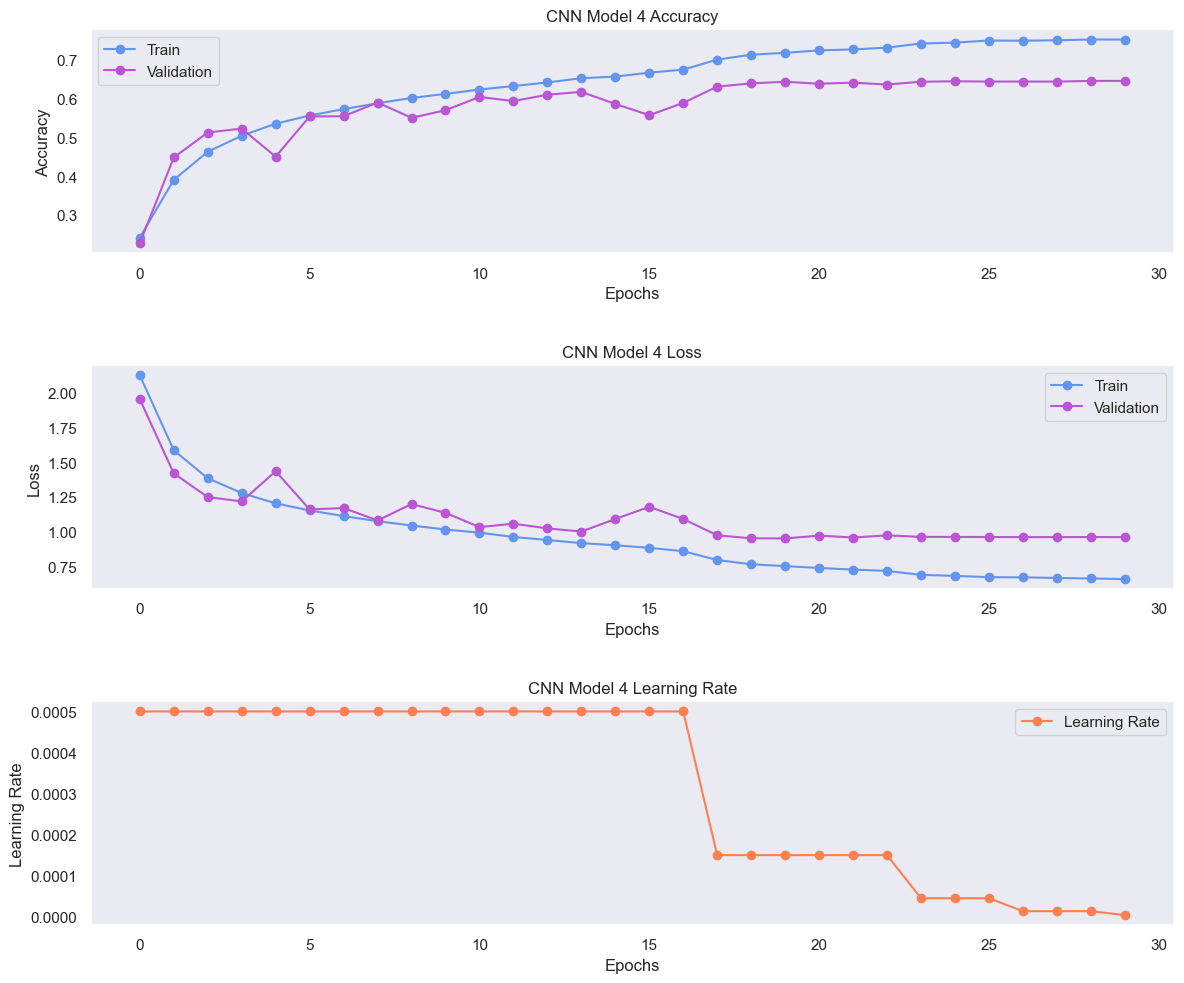

In [159]:
# Plot model loss and accuracy
hp.plot_hist(h4, 'CNN Model 4')

316/316 [==============================] - 2s 4ms/step


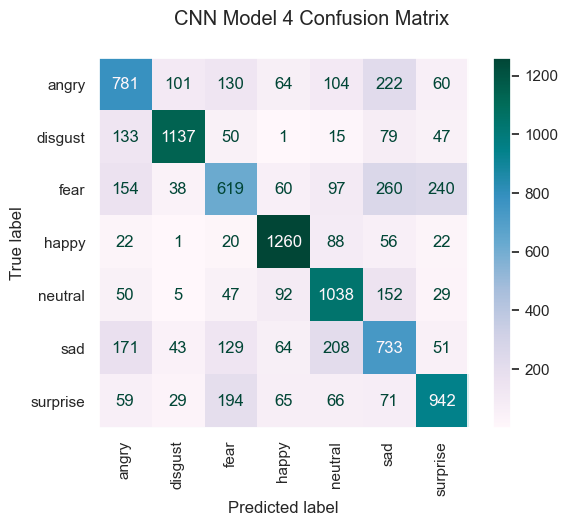

In [160]:
hp.plot_confusion_matrix(val,model4,'CNN Model 4 Confusion Matrix')

316/316 [==============================] - 1s 4ms/step


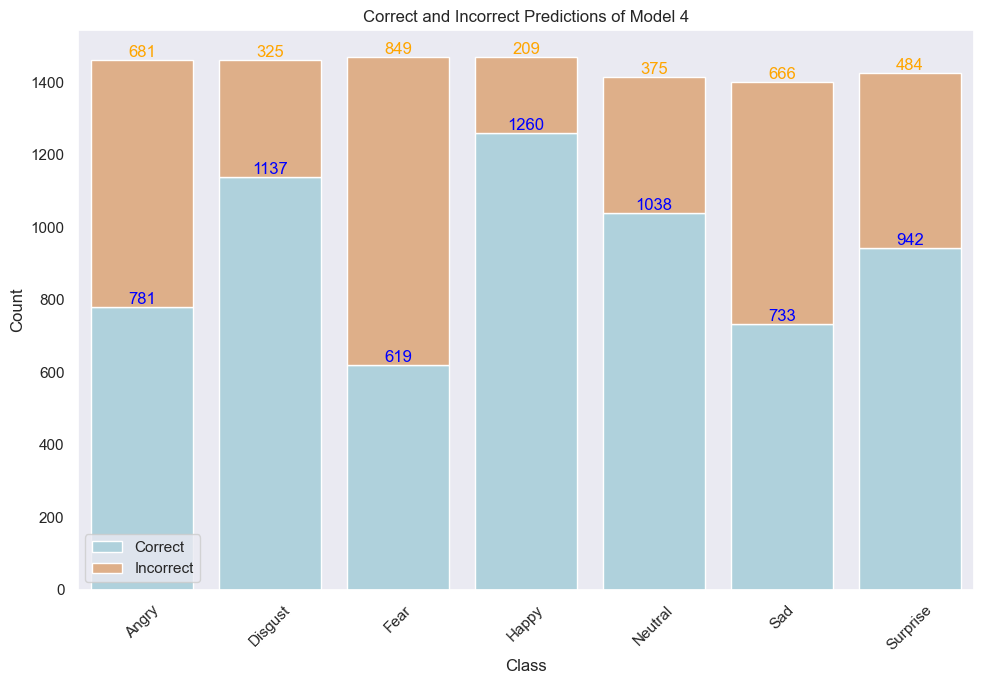

In [162]:
hp.plot_correct_dist(val, model4, 'Model 4')

Comparing the Confusion Matrix and bar graph of the distributions of correct/incorrect predictions in Model 4 with Model 3, we see the following highlights:

- Model 4 predicts more true postives in class:
    - angry (781) than Model 3 (697).
    - fear (619) than Model 3 (576)
    - happy (1260) than Model 3 (1248)
    - neutral (1038) than Model 3 (1017)

- Model 4 predicts less true postives in class:
    - disgust (1137) than Model 3 (1152)
    - sad (733) than Model 3 (737)
    - surprise (942) than Model 3 (942)

# Data Augmentation

It is evident that the `disgust` images are classified quite well from the performance of Model 1 - Model 4. This came as a surprise since this was the class that had the least amount of observations in the initial dataset (FER 2013).While more images were obtained from AffectNet, data augmentation was applied to the disgust class to account for class imbalance. Model 5 adds a data augmentation layer in hopes to improve its performance in classifying all classes. 

Random zoom and random contrast were applied to the train dataset in hopes to imrprove the model's performance in several ways: [Source](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)


- <u>Increase performance to variations</u>: adding these augmentations introduces variations to the training data. These can potentially help the model learn to recognize and generalize patterns in different scales and lighting conditions. Thus, the model can perform better to variations in the input data and improve it's performance to accurately classify unseen or real-world images.

- <u>Increased training data size</u>: adding a data augmentation layer increases the effective size of the training dataset. This provides the model with more observations to learn from. This may help the model learn more representative features from each class, leading to an improved performance.

- <u>Enhanced generalization</u>: by adding variation to the training data, this can prevent overfitting and improve the model's ability to generalize to new and unseen data. This can help the model focus on the essential features of a pattern in each class rather than specific/minute details that may be present in the original train dataset. 

In [ ]:
# Test on single image
train_path = './Data/Final_Data/train/neutral/'
img = img_to_array(load_img(train_path + 'Training_10078021.jpg'))
w = img.shape[0]
h = img.shape[1]
exp_img = np.expand_dims(img, axis=0)

In [8]:
# Setting up Augmentation model
#Source: https://www.tensorflow.org/tutorials/images/transfer_learning

data_augmentation = Sequential([
    RandomFlip('horizontal', input_shape=(h,w,1)),
    RandomZoom(0.1),                                 # Randomly zooms image by factor of 0.1
    RandomContrast(0.2)                              # Randomly adjusts contrast of iamge by factor of 0.2
])

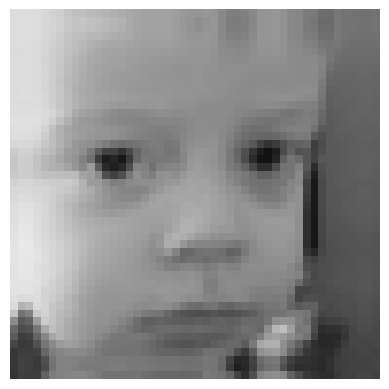

In [ ]:
# Test augmentation on single image
new_img_aug = data_augmentation(exp_img)
# Squeeze to normal image dimension
new_img = np.squeeze(new_img_aug)
# Show new image
plt.imshow(new_img * 1./255)
plt.axis('off') # Turn axes off
plt.show();

## Model 5

Compared to Model 4, Model 5 has the following difference in it's architecture:
- Data augmentation layer
- Increased drop out in 3rd Convolutional layer to account for overfitting
- Increased neuron size in 1st hidden layer so the model can extract and learn more features from dataset.


In [9]:
model5 = Sequential(name = 'model_5')

model5.add(layers.Input(shape = (h,w,1)))
model5.add(layers.Rescaling(1./255))

# Data Augmentation layer
model5.add(data_augmentation)                

#First Convolutional layer
model5.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))

#2nd Convolutional layer
model5.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))

#3rd Convolutional layer
model5.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))  
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.3))   #increased dropout from 0.2 to 0.3

#4th Convolutional layer
model5.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.3))

# 5th Convolutional layer
model5.add(Conv2D(258, kernel_size = (3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

# Flatten layer to feed into model
model5.add(Flatten())

#Fully connected layer
#1 Hidden Layer
model5.add(Dense(630, activation = 'relu'))            
model5.add(BatchNormalization())
model5.add(Dropout(0.6))  

#2 Hidden Layer
model5.add(Dense(528, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

# Output Layer
model5.add(Dense(7, activation = 'softmax'))

# print out summary of model
model5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 64)       256       
 ormalization)                                             

In [10]:
# Compile
model5.compile(
    optimizer= Adam(learning_rate = 0.00095), #Increased learning rate from 0.0005 to 0.00095
    loss = 'categorical_crossentropy',
    metrics = ['acc',
               metrics.Precision(),
               metrics.Recall(),
               metrics.AUC()]
)

In [11]:
es = EarlyStopping(patience = 10,
                   monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.3,   
                       patience = 2,
                       min_delta = 0.000001,
                       verbose = 1)

ck = ModelCheckpoint('./Models/model5.h5')

In [12]:
h5 = model5.fit(train, 
                validation_data = val,
                epochs = 25,             #Reduced epoch from 50 to 25
                callbacks = [es, lr, ck],
                verbose = 1)

Epoch 1/25
1263/1263 [==============================] - 43s 33ms/step - loss: 2.0971 - acc: 0.2334 - precision_1: 0.3433 - recall_1: 0.0738 - auc_1: 0.6064 - val_loss: 2.1256 - val_acc: 0.2021 - val_precision_1: 0.4058 - val_recall_1: 0.0597 - val_auc_1: 0.6157 - lr: 9.5000e-04
Epoch 2/25
1263/1263 [==============================] - 42s 33ms/step - loss: 1.5690 - acc: 0.3962 - precision_1: 0.6447 - recall_1: 0.1969 - auc_1: 0.7757 - val_loss: 1.5261 - val_acc: 0.4093 - val_precision_1: 0.7769 - val_recall_1: 0.1059 - val_auc_1: 0.7915 - lr: 9.5000e-04
Epoch 3/25
1263/1263 [==============================] - 42s 33ms/step - loss: 1.4017 - acc: 0.4598 - precision_1: 0.6832 - recall_1: 0.2587 - auc_1: 0.8270 - val_loss: 1.7865 - val_acc: 0.3738 - val_precision_1: 0.6763 - val_recall_1: 0.1939 - val_auc_1: 0.7256 - lr: 9.5000e-04
Epoch 4/25
1263/1263 [==============================] - 43s 34ms/step - loss: 1.3168 - acc: 0.4927 - precision_1: 0.7033 - recall_1: 0.2952 - auc_1: 0.8490 - val_l

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy |  Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |
|Model 2 | 0.6844 | 0.7449 | 0.9868 | 0.6309 |
|Model 3 | 0.6391 | 0.7629 | 0.9745 | 0.6313 |
|Model 4 | 0.6605 | 0.7511 | 0.9612 | 0.6446 |
|Model 5 | 0.9559 | 0.6358 | 0.9564 | 0.6340 |

Model 5 was trained for 25 epochs. 


* Validation Loss: Model 5 had a slightly lower validation loss (0.9564) compared to the Model 4 (0.9612). This suggests that Model 5 generalizes better and performance in terms of minimizing the error on unseen data.
* Validation Accuracy: Model 5 performed slightly worse than Model 4 on validation accuracy, with an accuracy of 63.40% compared to 64.14%. This indicates that Model 4 makes more accurate predictions on the validation set.
* Training Loss and Accuracy: However, Model 5 has a much higher training loss and  lower train accuracy than Model 4.

Overall, Model 5 is is performing worse in making accurate predictions on the validation set, than Model 4. Data augmentation helped with combatting with overfitting, but did not help with increasing the performance on the validation set.

In [15]:
h5.history['val_acc']

[0.20209921896457672,
 0.4093474745750427,
 0.3737993836402893,
 0.5128230452537537,
 0.45351025462150574,
 0.5641152858734131,
 0.5248044729232788,
 0.5122289657592773,
 0.6046143174171448,
 0.6070898175239563,
 0.5994653105735779,
 0.6148133873939514,
 0.6157045364379883,
 0.6170908212661743,
 0.6136251091957092,
 0.6279829740524292,
 0.6292702555656433,
 0.6294682621955872,
 0.6273888945579529,
 0.6324388980865479,
 0.6335281133651733,
 0.6325379014015198,
 0.6288741827011108,
 0.6321418285369873,
 0.6340231895446777]

In [16]:
# Save model history to csv file in Results
hp.model_scores_to_csv(model5, h5, 'data_aug')

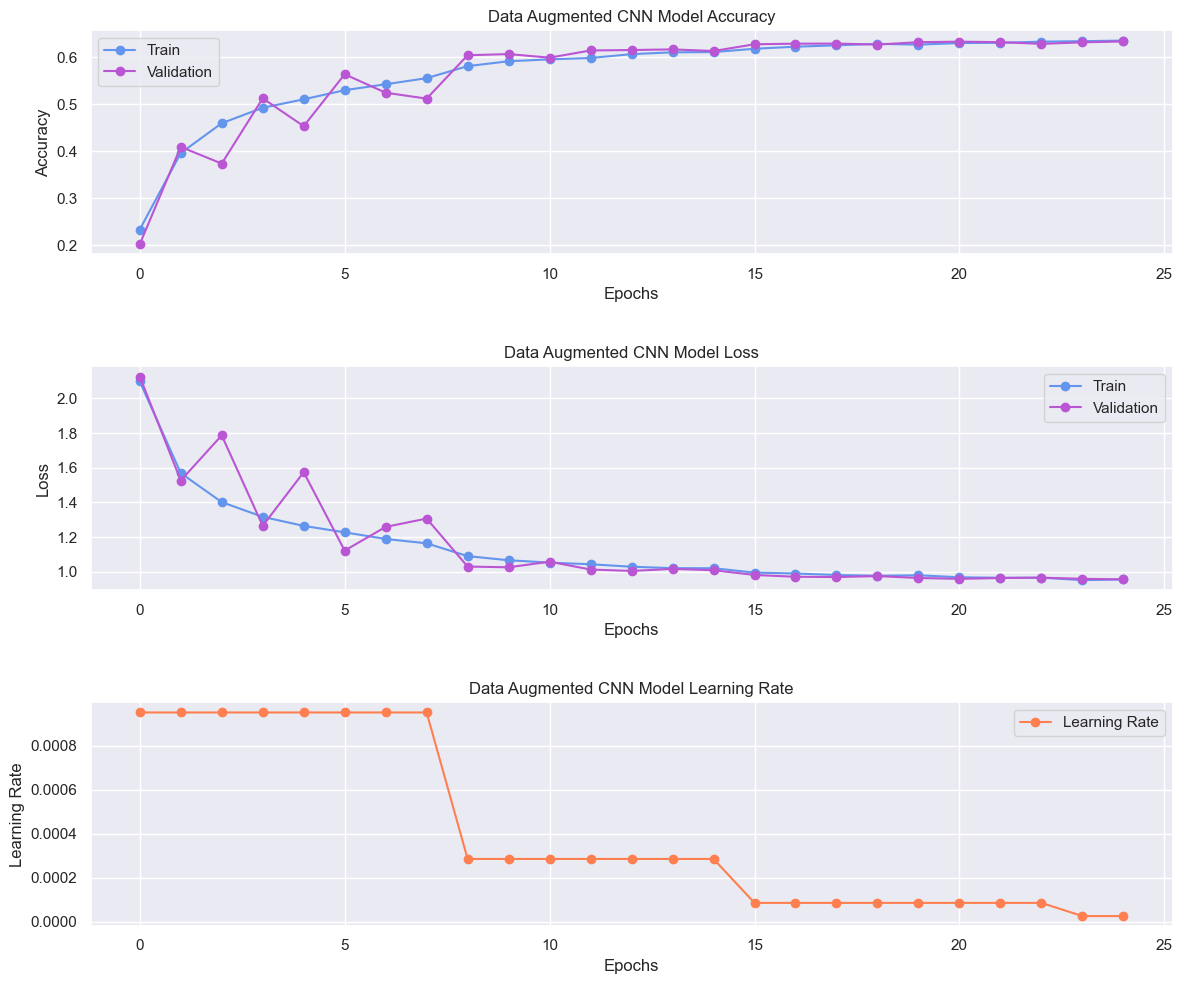

In [17]:
# Plot model loss and accuracy
hp.plot_hist(h5, 'Data Augmented CNN Model')

316/316 [==============================] - 1s 4ms/step


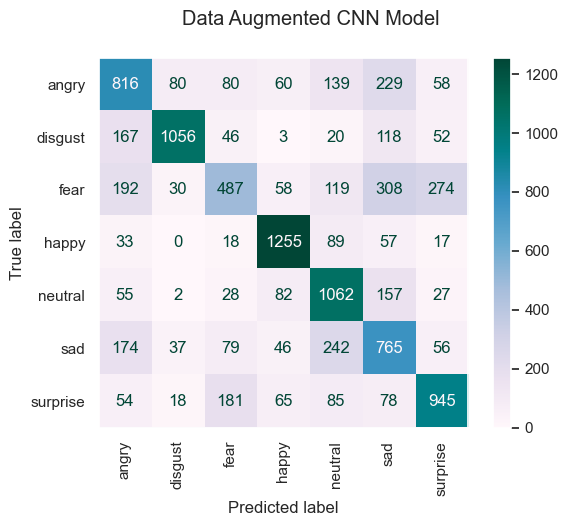

In [18]:
hp.plot_confusion_matrix(val,model5,'Data Augmented CNN Model')

316/316 [==============================] - 1s 4ms/step


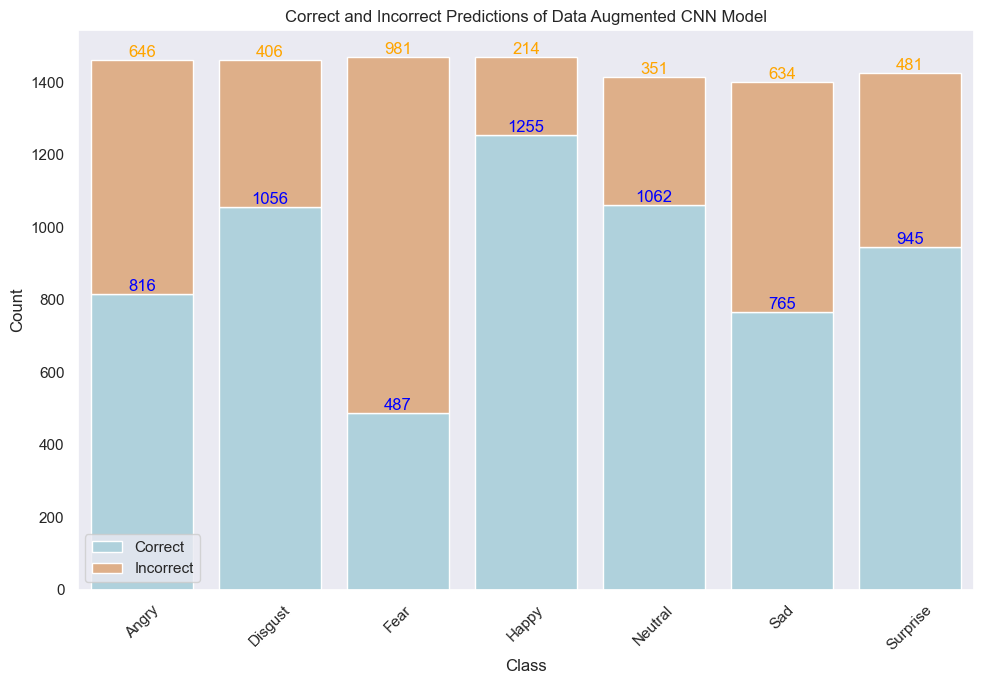

In [19]:
hp.plot_correct_dist(val, model5, 'Data Augmented CNN Model')

Comparing the Confusion Matrix and bar graph of the distributions of correct/incorrect predictions in Model 5 with Model 4, we see the following highlights:

- Model 5 predicts more true postives in class:
    - angry (816) than Model 4 (781)
    - disgust (1056) than Model 4 (1152)
    - neutral (1062) than Model 4 (1038)
    - sad (765) than Model 4 (733)
    - surprise (945) than Model 4 (942)

- Model 5 predicts less true postives in class:
    - fear (487) than Model 4 (619)
    - happy (1255) than Model 4 (1260)

What was surprising here is that data augmentation helped classify majority of the classes except class fear and happy.

# Ensemble Modeling

Since Models 2, 3 and 4 performed fairly similarly, an ensemble model was created in hopes that it will help boost the performance of predicting. 

**Ensemble modeling** helps the model improve the performance by building upon existing models. 

In [21]:
# Imports
from keras.layers import Input
from keras.models import Model
from keras.layers import Average
from tensorflow.keras.models import load_model

In [22]:
# Code inspo and modified from: https://www.youtube.com/watch?v=T7yGx4oo9BU&t=410s
# Step 1: Load the entire models
model2 = load_model('./Models/model2.h5')
model2 = Model(inputs=model2.inputs,
              outputs = model2.outputs,
              name = 'model_2')
model3 = load_model('./Models/model3.h5')
model3 = Model(inputs=model3.inputs,
              outputs = model3.outputs,
              name = 'model_3')
model4 = load_model('./Models/model4.h5')
model4 = Model(inputs=model4.inputs,
              outputs = model4.outputs,
              name = 'model_4')


# Step 2: Create the ensemble model
models = [model2, model3, model4]
input_shape = (48, 48, 1)  
input_layer = Input(shape=input_shape)

# Step 3: Add the layers from each individual model to the ensemble model and avg them
model_output = [model(input_layer) for model in models]
ensemble_outputs = Average()(model_output)   #Use Average layer to combine outputs of individual models


# Step 4: Create the ensemble model that takes the input and produces the outputs from individual models
ensemble_model = Model(inputs=input_layer, outputs=ensemble_outputs, name='ensemble')

# Step 5: Compile and fit the ensemble model
ensemble_model.compile(
    optimizer= Adam(learning_rate=0.00055),
    loss='categorical_crossentropy',
    metrics=['acc',])

# Add callbacks
es = EarlyStopping(patience = 10,
                   monitor = 'val_loss',
                   mode = 'min',
                  verbose = 1)

r_lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.2,
                       patience = 2,
                       min_delta = 0.000001,
                       verbose = 1)

ck = ModelCheckpoint(monitor = 'val_acc',   # Monitor val_acc and save model weights when val_acc is the highest
                     mode ='max',
                     filepath='./Models/ensemble1.h5')

# Step 6: Fit ensemble model on train and val dataset
h6 = ensemble_model.fit(train, validation_data=val, epochs=50, callbacks=[es, r_lr, ck])

Epoch 1/50
1263/1263 [==============================] - 59s 45ms/step - loss: 0.7106 - acc: 0.7468 - val_loss: 1.1463 - val_acc: 0.5626 - lr: 5.5000e-04
Epoch 2/50
1263/1263 [==============================] - 55s 44ms/step - loss: 0.7367 - acc: 0.7355 - val_loss: 1.0758 - val_acc: 0.6140 - lr: 5.5000e-04
Epoch 3/50
1263/1263 [==============================] - 56s 44ms/step - loss: 0.7422 - acc: 0.7331 - val_loss: 1.0643 - val_acc: 0.6200 - lr: 5.5000e-04
Epoch 4/50
1263/1263 [==============================] - 56s 44ms/step - loss: 0.7305 - acc: 0.7354 - val_loss: 1.0733 - val_acc: 0.6198 - lr: 5.5000e-04
Epoch 5/50
1263/1263 [==============================] - ETA: 0s - loss: 0.7330 - acc: 0.7355
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010999999940395356.
1263/1263 [==============================] - 56s 44ms/step - loss: 0.7330 - acc: 0.7355 - val_loss: 1.1032 - val_acc: 0.6154 - lr: 5.5000e-04
Epoch 6/50
1263/1263 [==============================] - 56s 44ms/step - loss

| **Model Performance** |
| :-: |

Model | Train Loss | Train Accuracy | Val Loss| Val Accuracy |
| :-: | :-: | :-: | :-: | :-: |
|Model 1 | 0.0196 | 0.9962 | 3.8947 | 0.5663 |
|Model 2 | 0.6844 | 0.7449 | 0.9868 | 0.6309 |
|Model 3 | 0.6391 | 0.7629 | 0.9745 | 0.6313 |
|Model 4 | 0.6605 | 0.7511 | 0.9612 | 0.6446 |
|Model 5 | 0.9559 | 0.6358 | 0.9564 | 0.6340 |
|Model 6 | 0.5205 | 0.8184 | 1.0003 | 0.6463 |

Model 6 was trained for 16 epochs. 


* Validation Loss: Model 6 had a slightly higher validation loss (1.0003) compared to the Model 5 (0.9564). This suggests that Model 5 generalizes better and performance in terms of minimizing the error on unseen data.
* Validation Accuracy: Model 6 performed slightly better than Model 5 on validation accuracy, with an accuracy of 64.63% compared to 63.40%. This indicates that Model 5 makes more accurate predictions on the validation set.
* Training Loss and Accuracy: Model 6 has a much lower training loss and  higher train accuracy than Model 5.

Overall, Model 6 is is performing better in making accurate predictions on the validation set, than Model 5, but the difference between train loss/val loss and train accuracy/val accuracy is much higher than Model 5, suggesting that Model6 is overfitting to the train dataset much more.

In [36]:
# Save model history to csv file in Results
hp.model_scores_to_csv(ensemble_model, h6, 'ensemble')

In [29]:
# serialize model to JSON
ensemble_model_json = ensemble_model.to_json()
with open("ensemble_model.json", "w") as json_file:
    json_file.write(ensemble_model_json)

# serialize weights to HDF5
ensemble_model.save_weights("ensemble_model.h5")
print("Saved model to disk")

Saved model to disk


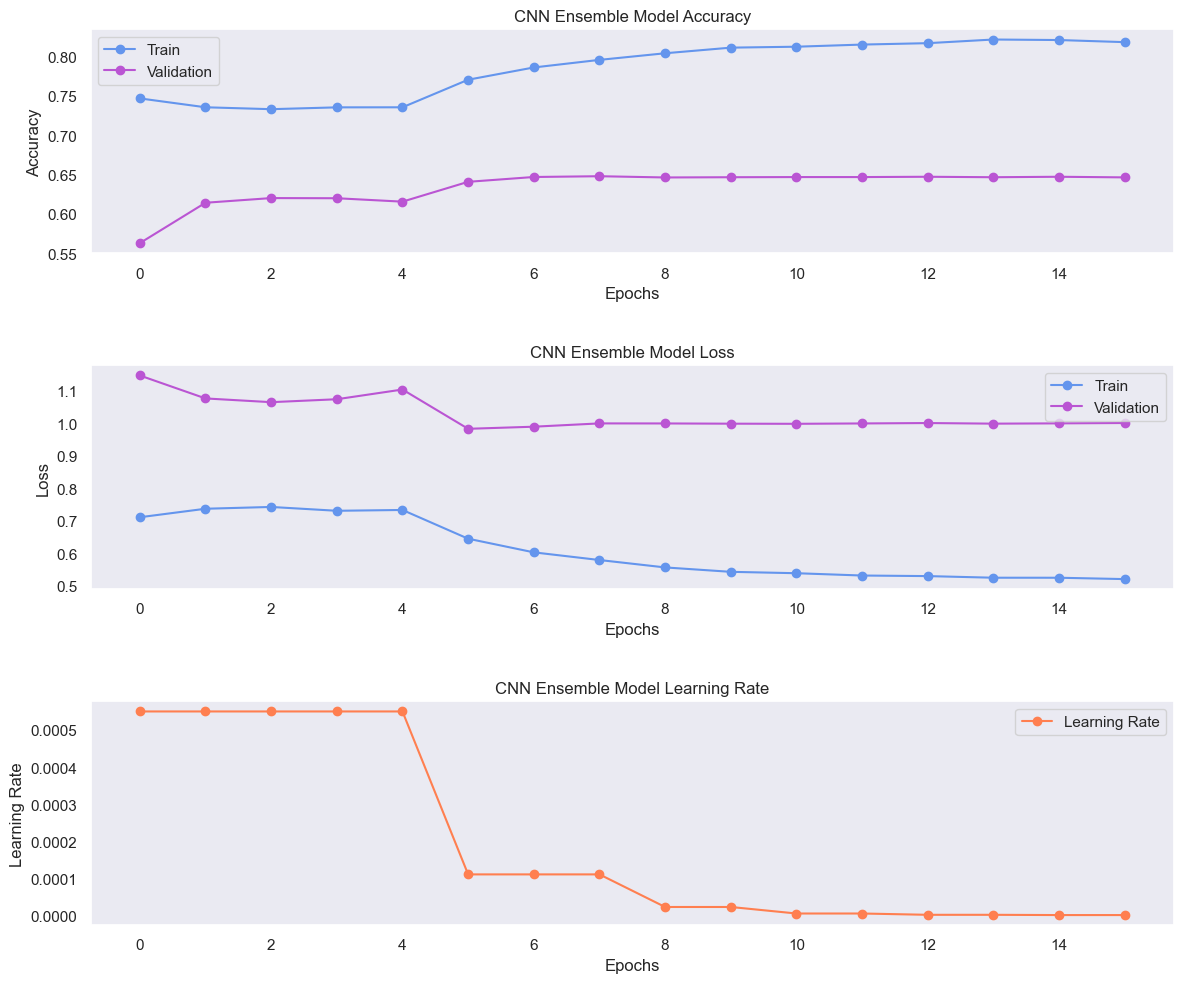

In [30]:
hp.plot_hist(h6, 'CNN Ensemble Model')

316/316 [==============================] - 3s 9ms/step


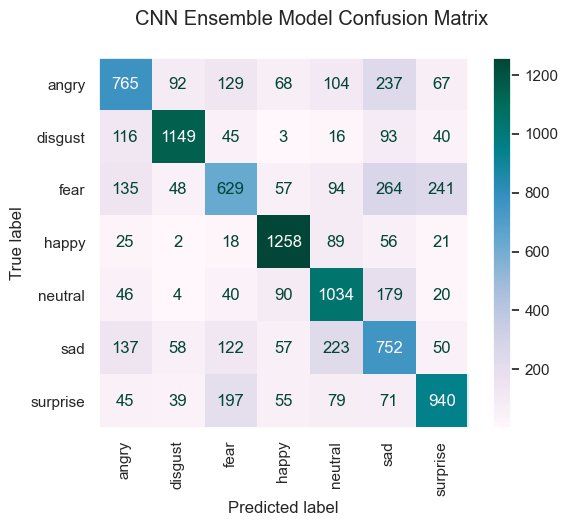

In [31]:
hp.plot_confusion_matrix(val, ensemble_model, 'CNN Ensemble Model Confusion Matrix')

316/316 [==============================] - 3s 8ms/step


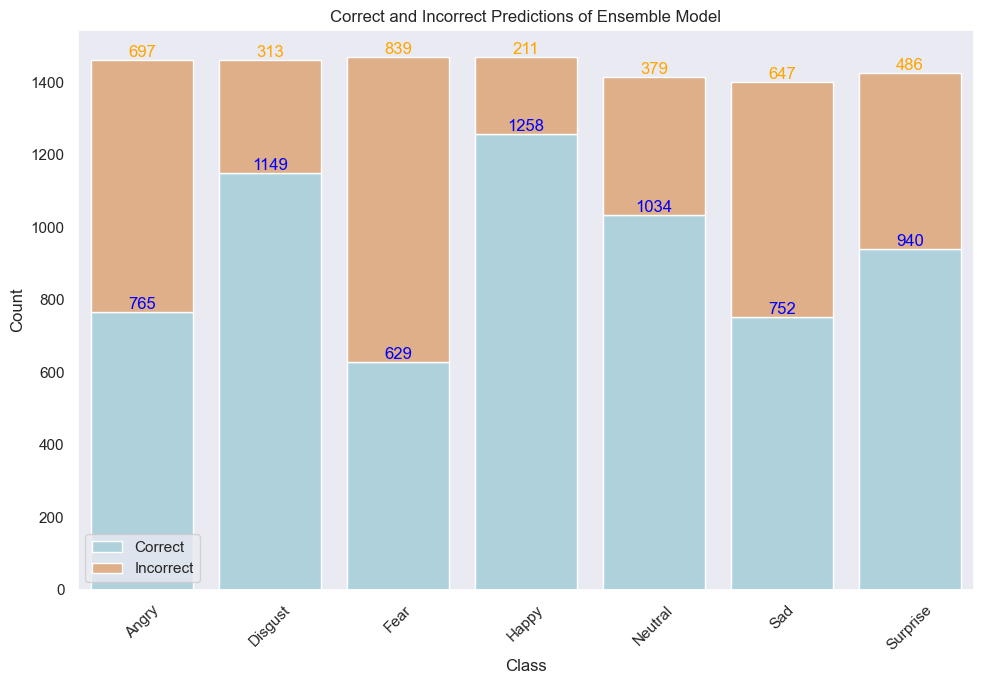

In [32]:
hp.plot_correct_dist(val, ensemble_model, 'Ensemble Model')

Comparing the Confusion Matrix and bar graph of the distributions of correct/incorrect predictions in the ensemble model with Model 5, we see the following highlights:

- Ensemble Model predicts more true postives in class:

    - disgust (1149) than Model 5 (1056)
    - fear (629) than Model 5 (487)
    - happy (1258) than Model 5 (1255)

- Ensemble Model predicts less true postives in class:
    - angry (765) than Model 5 (816)
    - neutral (1034) than Model 5 (1062)
    - sad (752) than Model 5 (765)
    - surprise (940) than Model 5 (945)


# Conclusion

8 custom CNN models along with 2 pretrained EfficientNet models were utilized and the best performing model was an ensemble model that incorporates the weights of models 2, 3, and 4. These models were selected for the ensemble model due to their validation accuracy being relatively close to one another. The ensemble model was able to accurately predict the validation dataset with a 64.46% accuracy. There was still evidence of overfitting as the model seemed to have a higher accuracy score on the training dataset with 81.84%. Moving forward, it would be best to retrieve more data with higher resolution than 48 x 48 so that the model could better learn facial features for each class. The benefit of having images that were small resolution is that my models were able to train and learn fairly quickly. It is also important to note that all images in this final dataset were converted into grayscale to match the FER-2013 images. In the future, further exploration and experimentation on color images should be applied. It would also be beneficial to apply the best model with OpenCV and implement a pre-trained Haar cascade classifier for face detection [Source](https://towardsdatascience.com/face-detection-with-haar-cascade-727f68dafd08) so that the model could be implemented on images in real-time. Overall, this project helps push the needle forward in helping individuals who have difficulty perceiving and understanding facial emotions by giving them a tool that could help them learn and identify facial emotions without any effort.